# Analyzing Videogame Playability with PySpark Using Players Reviews

## Big Data Computing final project - A.Y. 2022-2023

Prof. Gabriele Tolomei

MSc in Computer Science

La Sapienza, University of Rome

### Author

Ilaria De Sio - [desio.2064970@studenti.uniroma1.it](mailto:desio.2064970@studenti.uniroma1.it)

The project is based on the paper entitled *A Data-Driven Approach for Video Game
Playability Analysis Based on Players’ Reviews* in this case study, the definition of
playability analyzed consists of three basic concepts ”**functionality**, **usability**, and
**gameplay**” defined by the *framework of Paavilainen*.

The goal is to obtain an explicit
and simplified framework so that not only the intuitively quantified assessment of the
overall playability of the chosen game is obtained but also to analyze and be able
to view the information
that can be ”playability-informative” and ”non-playability-informative” divided into
the classes listed above.

## Define some global constants

In [1]:
# GITHUB
DATASET_URL = "https://raw.githubusercontent.com/iladesio/iladesio/Video_Game_Playability_Analysis/tree/main/dataset/data_clean.csv"
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
# GOOGLE DRIVE
GDRIVE_DIR = "/content/gdrive" # Your own mount point on Google Drive
GDRIVE_HOME_DIR = GDRIVE_DIR  # Your own home directory

# File Variable
GDRIVE_DATASET_FILE = GDRIVE_HOME_DIR + "/" + DATASET_URL.split("/")[-1]

In [ ]:
!pip install pyspark==3.3.0 spark-nlp==2.4.5
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 2.9 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 92, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 397, in resolve
    self._

## Import PySpark packages and other dependencies

In [ ]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark import SparkContext, SparkConf

from pyspark.ml import Pipeline
import re

import nltk
from nltk import *
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                set("spark.kryoserializer.buffer.max", "2000M").\
                set("spark.jars.packages","com.johnsnowlabs.nlp:spark-nlp_2.12:4.4.3").\
                setAppName("ProjectBigData").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
print(sc)
spark = SparkSession.builder.getOrCreate()

<SparkContext master=local[*] appName=ProjectBigData>


#1) Dataset initialization
I chose to use the dataset [https://doi.org/10.6084/m9.figshare.14222531.v1](https://doi.org/10.6084/m9.figshare.14222531.v1) directly provided by the authors of the paper containing the review data from Steam for **No Man’s Sky** in terms of playability by users.
This case of study is really interesting because this game was released on 2016, before which a social media “hype” had been evoked leading to an unprecedentedly high expectation.
Unexpectedly the release was disastrous, but for the last four years, the
game has been continuously maintained with its quality gradually increasing, which makes it a unique case where the changes in game quality is observable.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
game_dataset = spark.read.csv('drive/My Drive/data_clean.csv', header=True, inferSchema=True)
game_dataset.show(n=5)

## 1.1) Dataset Shape and Scheme

The dataset contains approximately 99k records of Steam's reviews.


* ```recommendationid```: The review ID;
* ```language```: Review language;
* ```review```: The text of user review;
* ```timestamp_created ```: The date a review is posted;
* ```timestamp_updated```: Update date of a review;
* ```voted_up```: True means it was a positive recommendation;
* ```votes_up```: The number of other users who found this review helpful;
* ```votes_funny```: How many other player think the review is funny;
* ```weighted_cote_score```: Helpfulness score;
* ```comment_count```: How many other player comment the review;
* ```steam_purchase```: Game purchased on steam or not;
* ```received_for_free```: Game received for free or not;
* ```written_during_early_access```:
* ```author_num_games_owned```: Number of games owned by the author;
* ```author_num_reviews```: How many other reviews has this user done;
* ```author_playtime_forever```: Number of total hours played by the author;
* ```author_playtime_last_two_weeks```: Number of hours played by the author in the last two weeks;
* ```author_last_played```:

-------





Cast the columns `"written_during_early_access", "voted_up", "steam_purchase"` from String to boolean

In [ ]:
game_dataset = game_dataset.withColumn('written_during_early_access', f.col('written_during_early_access').cast('boolean')) \
    .withColumn('voted_up', f.col('voted_up').cast('boolean')) \
    .withColumn('steam_purchase', f.col('steam_purchase').cast('boolean'))


Cast the columns `"author_num_games_owned", "author_num_reviews", "author_playtime_forever" and "author_playtime_last_two_weeks"`from String to Integer

In [ ]:
game_dataset = game_dataset.withColumn('author_num_games_owned', f.col('author_num_games_owned').cast(IntegerType())) \
    .withColumn('author_num_reviews', f.col('author_num_reviews').cast(IntegerType())) \
    .withColumn('author_playtime_forever', f.col('author_playtime_forever').cast(IntegerType())) \
    .withColumn('author_playtime_last_two_weeks', f.col('author_playtime_last_two_weeks').cast(IntegerType()))

In [ ]:
game_dataset.printSchema();

#2) Data Pre-processing
In this phase involves cleaning and transforming the raw data to ensure its quality and compatibility with the analysis.



## 2.1) Data Cleaning

From the data info above, we can already notice that there are missing values in review. Since our work is going to be heavily relying on this column, we have to clean it from these missing values. In addition, we also need to check for duplicated values following the standard data cleaning procedure.

In [ ]:
missing_counts = [game_dataset.where(f.col(c).isNull()).count() for c in game_dataset.columns]
for c, count in zip(game_dataset.columns, missing_counts):
    print("N. of missing values of column `{}` = {}".format(c, count))


In [ ]:
# Elimina le righe contenenti valori nulli dal DataFrame
game_dataset = game_dataset.na.drop()

# Visualizza il DataFrame risultante
game_dataset.show()


In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(game_dataset.count(), len(game_dataset.columns)))

In [ ]:

duplicates = game_dataset.groupBy('review').count().filter(f.col('count') > 1)
duplicates.show(truncate=False)



As we can see there are not actually equal reviews but with similar terms, most of them are very short reviews such as 'good' or 'amazing'. These reviews are still important for our classification task, so we will not drop them.

##2.2) Data Exploration

### 2.2.1)Analyze the number of reviews over time

The following line graph shows the trend in the number of reviews over time. As we can see the largest number of reviews within this dataset is in the first period of the game's release, **this suggests that there will be more negative reviews**.

In [ ]:
review_dates = game_dataset.select('timestamp_created').toPandas()
review_dates['timestamp_created'] = pd.to_datetime(review_dates['timestamp_created'])

review_count_by_date = review_dates.groupby(pd.Grouper(key='timestamp_created', freq='M')).size()

plt.figure(figsize=(12, 6))
plt.plot(review_count_by_date.index, review_count_by_date.values)
plt.xlabel('Dates')
plt.ylabel('Number of reviews')
plt.title('Trend in the number of reviews over time')
plt.xticks(rotation='vertical')
plt.show()


Now let's try to see how many reviews actually have been updated over time.

As we can see from the following line graph it suggests that users tend to edit or update their reviews less frequently than writing new reviews.

In [ ]:
review_data = game_dataset.select('timestamp_created', 'timestamp_updated').toPandas()

review_data['timestamp_created'] = pd.to_datetime(review_data['timestamp_created'])
review_data['timestamp_updated'] = pd.to_datetime(review_data['timestamp_updated'])

# Create a column indicating whether or not a review has been updated.
review_data['review_status'] = review_data['timestamp_created'] != review_data['timestamp_updated']

# Group by month and count the number of reviews initially written and updated
review_count_by_month = review_data.groupby(pd.Grouper(key='timestamp_created', freq='M')).agg({
    'review_status': ['sum', 'count']
}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(review_count_by_month['timestamp_created'], review_count_by_month[('review_status', 'count')], label='Reviews initially written')
plt.plot(review_count_by_month['timestamp_created'], review_count_by_month[('review_status', 'sum')], label='Updated Reviews')
plt.xlabel('Dates')
plt.ylabel('Number of reviews')
plt.title('Number of reviews written initially and updated over time')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()



###2.2.2) Distribution of the length of reviews

The following histogram provides an overview of the distribution of review lengths and can be used to better understand the text characteristics of reviews in the dataset.

In [ ]:
df_lengths = game_dataset.select('review', f.length('review').alias('review_length')).toPandas()
plt.figure(figsize=(10,6))

plt.hist(df_lengths['review_length'], bins=100)
plt.xlabel('Length of reviews')
plt.ylabel('Number of reviews')
plt.title('Histogram of the distribution of the length of reviews')
plt.show()


### 2.2.3) Play time in the last two weeks VS Total play time

The following scatter plot displays a comparison of the authors' playing time over the past two weeks with the total playing time recorded in the dataset. The goal of this graph is to identify any relationships or patterns between recent play time and total play time.

As evident from the plot, there is a noticeable trend where the playtime of the game decreases as more time passes since its release. This observation suggests that over time, user engagement and playtime for the game tend to decline.

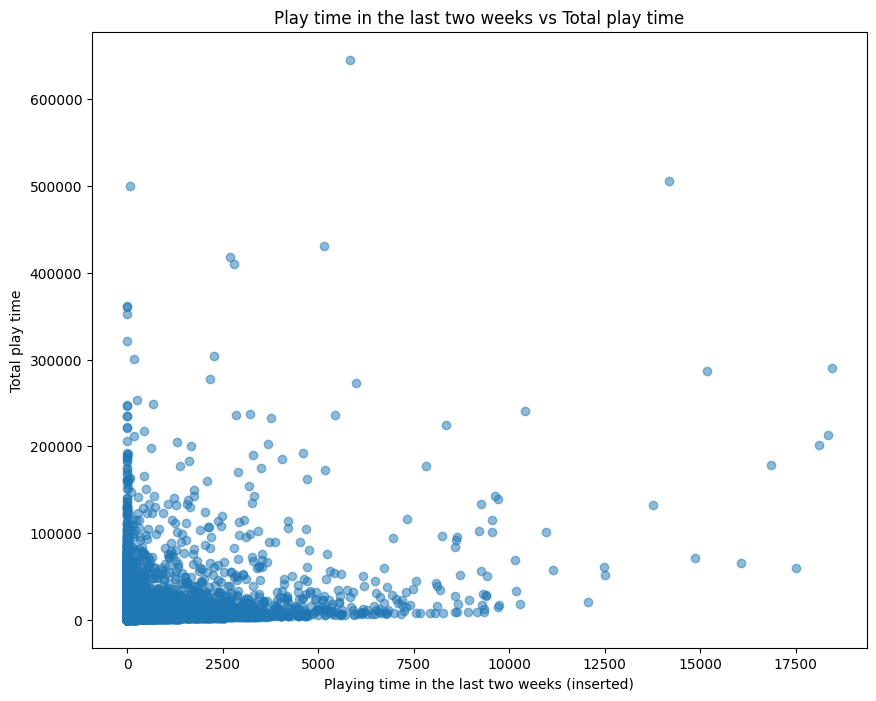

In [ ]:
playtime_data = game_dataset.select('author_playtime_forever', 'author_playtime_last_two_weeks').toPandas()

plt.figure(figsize=(10, 8))
plt.scatter(playtime_data['author_playtime_last_two_weeks'], playtime_data['author_playtime_forever'], alpha=0.5)
plt.xlabel('Playing time in the last two weeks (inserted)')
plt.ylabel('Total play time')
plt.title('Play time in the last two weeks vs Total play time')
plt.show()


#3) Topic Modeling

For topic modelling, we need only textual data, thus, we create a new dataframe only with the column of interest.

In [ ]:
text_col = 'review'
review_text = game_dataset.select(text_col).filter(f.col(text_col).isNotNull())

##3.1) Text-processing + Pipeline with Unigrams
During the text processing phase, it is important to remove reviews that consist solely of special characters. This type of reviews does not provide useful information and can cause ambiguity in their interpretation. Removing these reviews ensures that the analyzed data is consistent and understandable. After the removal, other text processing techniques can be applied, such as tokenization, normalization, stopwords removal, n-gram extraction, and POS tagging, to obtain a structured representation of the text and facilitate the extraction of meaningful information.

We will start with **DocumentAssembler** that converts data into Spark NLP annotation format that can be used by Spark NLP annotators.

In [ ]:
from sparknlp.base import DocumentAssembler

documentAssembler = DocumentAssembler() \
     .setInputCol('review') \
     .setOutputCol('document')

The next step is the **Tokenizer** that divides a text into smaller units called "tokens". This process is called "tokenization" and is used to split the text into words, phrases, or other meaningful units.

In [ ]:
from sparknlp.annotator import Tokenizer

tokenizer = Tokenizer() \
     .setInputCols(['document']) \
     .setOutputCol('tokenized')

Now the **Normalizer** standardizes the text through various operations such as removing punctuation characters, converting to lowercase, and other transformations to obtain a normalized form of the text.

In [ ]:
from sparknlp.annotator import Normalizer

normalizer = Normalizer() \
     .setInputCols(['tokenized']) \
     .setOutputCol('normalized') \
     .setLowercase(True)

The **LemmatizerModel** converts words to their base form or lemmas, reducing them to their canonical form, thereby reducing the complexity and variety of the words.

In [ ]:
from sparknlp.annotator import LemmatizerModel

lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemmatized')

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [ ]:
nltk.download('stopwords')

from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The downloaded list of stop words we will input into **StopWordsCleaner** that will remove all such words from our lemmatized text.

In [ ]:
from sparknlp.annotator import StopWordsCleaner

stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemmatized']) \
     .setOutputCol('unigrams') \
     .setStopWords(eng_stopwords)

In addition to unigrams, I have decided to incorporate n-grams for topic modeling as well, as they help in further refining topics. **NGramGenerator** is used to generate these n-grams.

> Example **Unigram**: "game";

> Example N-gram:
>>**Bigrams** (2-grams): "natural language";
>>>**Trigrams** (3-grams): "text classification models";






In [ ]:
from sparknlp.annotator import NGramGenerator

ngrammer = NGramGenerator() \
    .setInputCols(['lemmatized']) \
    .setOutputCol('ngrams') \
    .setN(3) \
    .setEnableCumulative(True) \
    .setDelimiter('_')

I chose to use the pre-trained **Perceptron** model provided by spark-nlp, it is a machine learning model used for Part-of-Speech (POS) tagging. It assigns grammatical categories to words in a sentence. The model uses a simplified neural network called perceptron and is trained on labeled examples to learn the patterns and weights for accurate word tagging.

In [ ]:
from sparknlp.annotator import PerceptronModel

pos_tagger = PerceptronModel.pretrained('pos_anc') \
    .setInputCols(['document', 'lemmatized']) \
    .setOutputCol('pos')

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


Now trasform the data with the **Finisher**.

In [ ]:
from sparknlp.base import Finisher

finisher = Finisher() \
     .setInputCols(['unigrams', 'ngrams', 'pos'])

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline() \
     .setStages([documentAssembler,
                 tokenizer,
                 normalizer,
                 lemmatizer,
                 stopwords_cleaner,
                 pos_tagger,
                 ngrammer,
                 finisher])

In [ ]:
processed_review = pipeline.fit(review_text).transform(review_text)

In [ ]:
processed_review.limit(5).show()

+--------------------+--------------------+--------------------+--------------------+
|              review|   finished_unigrams|     finished_ngrams|        finished_pos|
+--------------------+--------------------+--------------------+--------------------+
|game is k. random...|[game, k, random,...|[game, be, k, ran...|[NN, VB, NN, JJ, ...|
|you gotta grind f...|[gotta, grind, ho...|[you, gotta, grin...|[PRP, VB, VB, IN,...|
|             Awesome|           [awesome]|           [awesome]|                [JJ]|
|great exploration...|[great, explorati...|[great, explorati...|[JJ, NN, JJ, NN, ...|
|Its fun to just g...|[fun, get, lose, ...|[it, fun, to, jus...|[PRP, NN, TO, RB,...|
+--------------------+--------------------+--------------------+--------------------+



##3.2) Extended pipeline with N-grams
I think it is beneficial to incorporate n-grams into our NLP pipeline to improve the accuracy of topic modeling. However, currently the n-grams in our pipeline are disorganized and include many ambiguous combinations. To solve this problem, we can apply a filter based on grammatical categories (Part-of-Speech) to exclude odd word combinations and keep only relevant ones. For example, we can limit PoS combinations in n-grams to pairs such as adjective + noun,based on the purpose. In addition, we can exclude certain POS categories from our unigrams to avoid the use of functional words that might adversely affect topic modeling.

In [ ]:
from pyspark.sql import types as t

udf_join_arr = f.udf(lambda x: ' '.join(x), t.StringType())
processed_review  = processed_review.withColumn('finished_pos', udf_join_arr(f.col('finished_pos')))

Next, we initiate another Spark NLP pipeline to obtain PoS tag n-grams that align with word n-grams.

> The pipeline to follow is the same as before but applied to the PoS tags
>>[D.Assembler->Tokenizer->N-Gram.Generator->Finisher]






In [ ]:
pos_documentAssembler = DocumentAssembler() \
     .setInputCol('finished_pos') \
     .setOutputCol('pos_document')

In [ ]:
pos_tokenizer = Tokenizer() \
     .setInputCols(['pos_document']) \
     .setOutputCol('pos')


Similarly, we generate n-grams from them using the same approach we employed for words.

In [ ]:
pos_ngrammer = NGramGenerator() \
    .setInputCols(['pos']) \
    .setOutputCol('pos_ngrams') \
    .setN(3) \
    .setEnableCumulative(True) \
    .setDelimiter('_')

In [ ]:
pos_finisher = Finisher() \
     .setInputCols(['pos', 'pos_ngrams'])

Now the creation of the new Pipeline

In [ ]:

pos_pipeline = Pipeline() \
     .setStages([pos_documentAssembler,
                 pos_tokenizer,
                 pos_ngrammer,
                 pos_finisher])

In [ ]:
processed_review = pos_pipeline.fit(processed_review).transform(processed_review)

Here are the word n-grams along with their corresponding PoS n-grams.

In [ ]:
processed_review.select('finished_ngrams', 'finished_pos_ngrams').limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

We are now prepared to eliminate PoS tags from our data that are not useful for topic modeling analysis. Firstly, let's create a function specifically designed for filtering unigrams.
Ho deciso di escludere queste categorie di PoS tags non utili al mio studio :

> **Determiners**: DT such as "the", "a/an”, "this";

> **Personal Pronouns**: PRP such as "I", "you", "he/she";

> **Conjunctions**: CC such as "and", "but", "or";












In [ ]:
def filter_pos(words, pos_tags):
    return [word for word, pos in zip(words, pos_tags)
            if pos not in ['DT', 'PRP', 'CC']]

udf_filter_pos = f.udf(filter_pos, ArrayType(StringType()))

In [ ]:
processed_review = processed_review.withColumn('filtered_unigrams',
                                               udf_filter_pos(f.col('finished_unigrams'),
                                                              f.col('finished_pos')))

This is the appearance of filtered unigrams.

In [ ]:
processed_review.select('filtered_unigrams','review').limit(10).show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_unigrams                                                                                                                           |review                                                                                                                                                                                                                                                                     |
+--------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------

Now exclude inappropriate combinations of PoS tags in n-grams. We will create the custom function using the same approach as before. Since we are working with bi- and trigrams, we have to limit the allowed POS tags for both cases.

In [ ]:
def filter_pos_combs(words, pos_tags):
    return [
        word for word, pos in zip(words, pos_tags)
        if (
            len(pos.split('_')) == 2 and \
            pos.split('_')[0] in ['JJ', 'NN', 'NNS', 'VB', 'VBP', 'VBZ','RB','VBN'] and \
            pos.split('_')[1] in ['JJ', 'NN', 'NNS', 'RB','VBZ']
        ) \
        or (
            len(pos.split('_')) == 3 and \
            pos.split('_')[0] in ['JJ', 'NN', 'NNS', 'VB', 'VBP', 'VBZ','RB','VBN'] and \
            pos.split('_')[1] in ['JJ', 'NN', 'NNS', 'VB', 'VBP','VBZ','RB'] and \
            pos.split('_')[2] in ['NN', 'NNS']
        )
    ]

udf_filter_pos_combs = f.udf(filter_pos_combs, t.ArrayType(t.StringType()))

In [ ]:
processed_review = processed_review.withColumn('filtered_ngrams',
                                               udf_filter_pos_combs(f.col('finished_ngrams'),
                                                                    f.col('finished_pos_ngrams')))

In [ ]:
processed_review.select('filtered_ngrams').limit(10).show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_ngrams                                                                                                                                                           |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[be_k, k_random, random_gen, voice_act, get_old, swell_time, game_be_k, k_random_gen]                                                                                     |
|[sci_fi, fi_then, game_other, other_wise, wise_idk, other_wise_idk]                                                                                                       |
|[]                                                                                                                                    

So that we have unigrams and n-grams stored in separate columns in the dataframe, let's merge them together.

In [ ]:
processed_review = processed_review.withColumn('final',
                                               f.concat(f.col('filtered_unigrams'),
                                                      f.col('filtered_ngrams')))

In [ ]:
processed_review.select('final').limit(10).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|final                                                                                                                                                                                                                                                                                                                |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[game, k, random, gen, preset, voice, act, old, none, less, swe

In [ ]:
processed_review.printSchema()

root
 |-- review: string (nullable = true)
 |-- finished_unigrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- finished_ngrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- finished_pos: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- finished_pos_ngrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_unigrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_ngrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- final: array (nullable = true)
 |    |-- element: string (containsNull = true)



##3.3) Feature Extraction(TF-IDF)

The first is TF-IDF that is a document representation technique that combines two key concepts: **term frequency** (TF) and inverse **document frequency** (IDF).

Term Frequency (TF): Measures the frequency of a term within a specific document. The more frequently a term appears in a document, the higher its TF value will be for that document.

In [ ]:
from pyspark.ml.feature import CountVectorizer

tfizer = CountVectorizer(inputCol='final', outputCol='tf_features')
tf_model = tfizer.fit(processed_review)
tf_result = tf_model.transform(processed_review)

Inverse Document Frequency (IDF): Measures the importance of a term in the entire document corpus. The IDF value of a term increases when it appears rarely in the corpus.

In [ ]:
from pyspark.ml.feature import IDF

idfizer = IDF(inputCol='tf_features', outputCol='tf_idf_features')
idf_model = idfizer.fit(tf_result)
tfidf_result = idf_model.transform(tf_result)

##3.4) LDA
Now, we can proceed with the topic modeling using Latent Dirichlet Allocation (LDA) on our dataset. For this algorithm, we need to specify the number of topics we believe are present in our data, as well as the number of iterations to run the LDA algorithm. Once we have set these parameters, we can initialize the LDA model and train it on our data.

In [ ]:
tfidf_result.printSchema()
tfidf_result.select('tf_idf_features')

root
 |-- review: string (nullable = true)
 |-- finished_unigrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- finished_ngrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- finished_pos: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- finished_pos_ngrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_unigrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_ngrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- final: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf_features: vector (nullable = true)
 |-- tf_idf_features: vector (nullable = true)



DataFrame[tf_idf_features: vector]

To obtain a better understanding of each topic, we can specify the desired number of top words we want to examine.



During several trials for the topic generation process, I observed that when more than 10 topics are used, the coherence score tends to converge toward a value indicative of artificial coherence, that is, when it is too close to 1. Artificial coherence occurs when the generated topics appear to be consistent with each other, but may lack specificity or may not accurately reflect the information structure of the data.

Therefore, I decided to use a topic number of 10.

In [ ]:
from pyspark.ml.clustering import LDA

num_topics = 10
max_iter = 30
num_top_words = 100

ldaTF = LDA(k=num_topics, maxIter=max_iter, featuresCol='tf_idf_features')
lda_modelTF = ldaTF.fit(tfidf_result)


In order to interpret and visualize the words that represent the identified topics, we need to convert the word IDs back into their corresponding actual words. To achieve this, we can define a custom function that performs this conversion.

In [ ]:
vocab = tf_model.vocabulary

def get_words(token_list):
     return [vocab[token_id] for token_id in token_list]

udf_to_words = f.udf(get_words, t.ArrayType(t.StringType()))

In [ ]:
topics = lda_modelTF.describeTopics(num_top_words).withColumn('topicWords', udf_to_words(f.col('termIndices')))
topics.select('topic', 'topicWords').show(truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##3.5) Measure of Topic Coherence Measure
The **topic coherence measure** provided by Gensim is a tool that evaluates the accuracy and coherence of topics generated by a topic model. It helps assess how interpretable and distinct the topics are from each other. The coherence measure compares the keywords within a topic and assesses their statistical or semantic coherence. By using methods like u_mass or c_v, the coherence measure calculates a score that reflects the coherence of the keywords.

In [ ]:
# Unisci gli array di parole in un unico array per ogni topic
merged_words_df = topics.groupby("topic").agg(f.flatten(f.collect_list("topicWords")).alias("document"))

# Converti il DataFrame Spark in una lista di documenti Python
document_list = merged_words_df.select("document").rdd.flatMap(lambda x: x[0]).collect()

In [ ]:
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
import json
import sys
import pandas as pd

output_file_json = "topicGenerationDEF.json"  # File JSON di output
output_file_txt = "topicGenerationDEF.txt"  # File TXT di output

# Creating the Gensim dictionary
topic_words_list = [row['topicWords'] for row in topics.collect()]
dictionary = Dictionary(topic_words_list)

# Apri il file JSON per scrivere i dati JSON
with open(output_file_json, "w") as json_file:
    output_data = []  # Lista per memorizzare i dati di output

    for row in topics.collect():
        topic_id = row['topic']
        topic_words = row['topicWords']

        # Creating the Gensim corpus for the current topic.
        corpus = [dictionary.doc2bow(topic_words)]

        # Calculating the degree of consistency for the current topic.
        coherence_model = CoherenceModel(topics=[[word for word in topic_words]], texts=topic_words_list, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()

        topic_data = {
            "topic_id": topic_id,
            "coherence_score": round(coherence_score, 2),
            "top_words": topic_words
        }

        output_data.append(topic_data)

    json.dump(output_data, json_file)  # Scrivi i dati JSON nel file

# Converti output_data in un DataFrame
df = pd.DataFrame(output_data)

# Scrivi i dati in formato testuale nel file TXT
with open(output_file_txt, "w") as txt_file:
    for topic_data in output_data:
        txt_file.write(f"Topic ID: {topic_data['topic_id']}\n")
        txt_file.write(f"Coherence Score: {topic_data['coherence_score']}\n")
        txt_file.write(f"Top Words: {', '.join(topic_data['top_words'])}\n")
        txt_file.write("\n")



##3.6) WordCloud

In [ ]:
df = spark.read.json("topicGenerationDEF.json")
topics_df = df.select('topic_id', 'coherence_score', 'top_words')

In [ ]:
topics_df.printSchema()

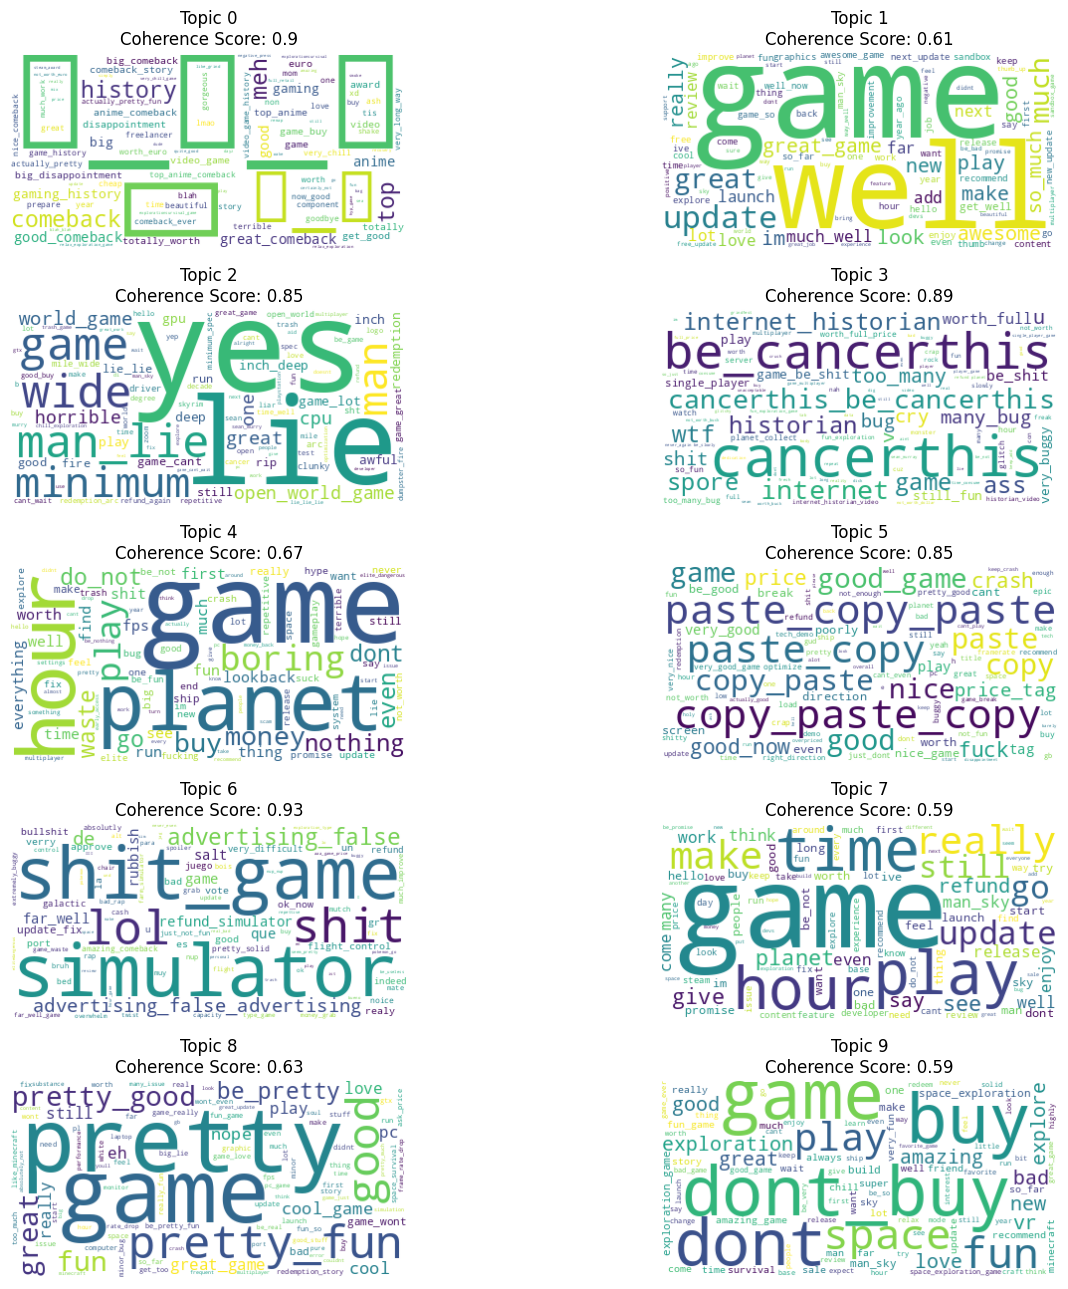

In [ ]:
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from wordcloud import WordCloud

topics_df=topics_df.toPandas()

# Calculate grid layout size
num_topics = len(topics_df)
num_cols = 2  # Set the number of columns in the grid
num_rows = (num_topics + num_cols - 1) // num_cols

# Define the desired plot size
plot_width = 15
plot_height = 13

# Create a grid layout for word clouds with the specified plot size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(plot_width, plot_height))

# Generate word clouds for each topic and display information
for i, ax in enumerate(axes.flatten()):
    if i < num_topics:
        topic_data = topics_df.iloc[i]
        topic_id = topic_data["topic_id"]
        coherence_score = topic_data["coherence_score"]
        top_words = topic_data["top_words"]

        wordcloud = WordCloud(background_color="white").generate(" ".join(top_words))

        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title(f"Topic {topic_id}\nCoherence Score: {coherence_score}", fontsize=12)
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()

##3.7) Choosing the most representative topics
I chose from these 10 topics the most representative ones based on the pre-requisites chosen at the beginning for this study:



> **FUNCTIONALITY**
*   POSITIVE (Topic ID 5): This topic seems to revolve around positive comments regarding the functionality of the game, such as smoothness, stability, and optimization. Users may have mentioned a seamless gaming experience and overall good performance of the game.
*   NEGATIVE (Topic ID 2): This topic appears to involve criticisms and negative comments about the game's functionality. It may address performance issues, bugs, poor optimization, or other technical difficulties that negatively affected users' gaming experience.


> **GAMEPLAY**
*   POSITIVE (Topic ID 0): This topic seems to focus on positive comments regarding the gameplay aspect of No Man's Sky. Users may have mentioned fun, quality of the gaming experience, interest in gameplay mechanics, exploration, and other positive features related to gameplay.
*   NEGATIVE (Topic ID 3): This topic contains criticisms and negative comments about the game's gameplay. It could include mentions of boredom, repetitiveness, lack of interesting content, or other negative aspects associated with the gaming experience.

> **USABILITY**
*   POSITIVE (Topic ID 9): This topic appears to discuss positive aspects regarding the usability of the game, such as ease of learning, intuitive interface, or other features that enhanced users' overall experience.
*   NEGATIVE (Topic ID 6): This topic seems to focus on criticisms or negative comments regarding the game's usability. It may address issues with navigation, difficult controls, a confusing interface, or other aspects that made interaction with the game challenging or frustrating.

**Others** (Topic ID 1,Topic ID 4,Topic ID 7): This topic doesn't clearly fit into the specified categories but may include miscellaneous comments and opinions that don't specifically focus on functionality, gameplay, or usability of the game. It could touch on various themes such as game purchase, price, gameplay expectations, or other general considerations.

#4) First Thesis of Machine Learning predictions
Does there exist a relationship between the **text of the review** and the **number of votes up** that it receives? Can we predict this value with a Machine Learning model?

##4.1) Analysis of the distribution of votes_up column

In [ ]:

# Calcola il valore minimo e massimo della colonna desiderata
min_value = game_dataset.agg(f.min(game_dataset['votes_up'])).collect()[0][0]
max_value = game_dataset.agg(f.max(game_dataset['votes_up'])).collect()[0][0]

# Visualizza il valore minimo e massimo
print("Valore minimo:", min_value)
print("Valore massimo:", max_value)


Valore minimo: 0
Valore massimo: 16993


**We consider as "useful reviews " only those reviews that exceed 96% of other ratings.**

In [ ]:
votes_up_for_useful_review = game_dataset.approxQuantile("votes_up", [0.96], 0)[0]
df_selected = game_dataset.select('review', 'votes_up')

In [ ]:
distribution = df_selected.groupBy('votes_up').agg(f.count('*').alias('count')).orderBy('votes_up')
distribution.show(truncate=False)

+--------+-----+
|votes_up|count|
+--------+-----+
|0       |42636|
|1       |18329|
|2       |11278|
|3       |7075 |
|4       |4755 |
|5       |3512 |
|6       |2464 |
|7       |1830 |
|8       |1461 |
|9       |1074 |
|10      |853  |
|11      |713  |
|12      |553  |
|13      |428  |
|14      |352  |
|15      |301  |
|16      |221  |
|17      |165  |
|18      |182  |
|19      |145  |
+--------+-----+
only showing top 20 rows



In [ ]:

# Impostare l'opzione per consentire operazioni su frame di dati diversi
spark.conf.set('spark.sql.compute.ops_on_diff_frames', 'true')

# Creare un DataFrame Spark con recensioni utili basate sul valore del quantile
useful_reviews_df = game_dataset.filter(f.col('votes_up') >= votes_up_for_useful_review)

# Campionamento di un sottoinsieme di recensioni non utili basato sulla proporzione
not_useful_reviews_df = game_dataset.filter(f.col('votes_up') < votes_up_for_useful_review)

# Reimpostare l'opzione per le operazioni su frame di dati diversi
spark.conf.unset('spark.sql.compute.ops_on_diff_frames')

# Calcola il valore massimo nella colonna 'nome_colonna'
print("Reviews with votes_up values between [",useful_reviews_df.agg(f.min('votes_up')).collect()[0][0],",",useful_reviews_df.agg(f.max('votes_up')).collect()[0][0],"]")
print("Number of review not useful",not_useful_reviews_df.count())
print("Number of review useful",useful_reviews_df.count())


Sono state selezionati come UTILI le recensioni con valori di votes_up compresi tra [ 11 , 16993 ]
numero righe review non utili 95267
numero righe review utili 4690


In [ ]:
# Merging DataFrames of useful and not-so-useful reviews.
restricted_df = useful_reviews_df.union(not_useful_reviews_df)

Defining the UDF function to assign the output label (0=not useful, 1=useful)

In [ ]:
udf_y = f.udf(lambda x: 0 if x < votes_up_for_useful_review else 1, IntegerType())

# Add new column 'useful'
restricted_df = restricted_df.withColumn('useful', udf_y(f.col('votes_up')))


###4.1.1) Data Distribution before Balancing


In [ ]:
df_useful = restricted_df.filter(restricted_df['useful'] == 1)
df_not_useful = restricted_df.filter(restricted_df['useful'] == 0)

In [ ]:
print(f"There are {df_not_useful.count()} reviews that are NOT useful before balancing")
print(f"There are {df_useful.count()} reviews that are useful before balancing")
fig, ax = plt.subplots()
x = ['Not Useful', 'Useful']
y = [df_not_useful.count(), df_useful.count()]
ax.bar(x, y, color=['blue', 'orange'])
ax.set_ylabel('Number of reviews')
ax.set_title('Data Distribution before balancing')
plt.show()

### 4.1.2)Undersampling on not useful reviews
Since the dataframe is very unbalanced, given the clear majority and overwhelming power of the useful reviews, I decided to sub-sample on them, so as to have a ratio 55% for the not useful reviews, 45% for the helpful, representative of a real case where very often in sites like steam there osno reviews containing even a single word or smiley and particularly suitable for the quality of this dataset.

0.8 is called **the weight factor** it represents the proportion or weight you want to assign to the ratio between the count of unhelpful reviews and the count of helpful reviews

In [ ]:
ratio = float(df_useful.count()) / df_not_useful.count()
#1/ratio indicates the relative weight of nonuseful rows to useful rows,
# so as to balance the number of rows in the two sets.
df_not_useful = df_not_useful.sample(False, 1/ratio)
df_balanced = df_not_useful.unionAll(df_useful)


In [ ]:
"""ratio = float(df_not_useful.count()) / df_useful.count()

df_not_useful = df_not_useful.sample(False, 1/ratio)

df_balanced = df_not_useful.unionAll(df_useful)"""

In [ ]:
print("numero utili:",df_balanced.filter(df_balanced['useful'] == 1).count())
print("numero non utili:",df_balanced.filter(df_balanced['useful'] == 0).count())

numero utili: 4688
numero non utili: 4642


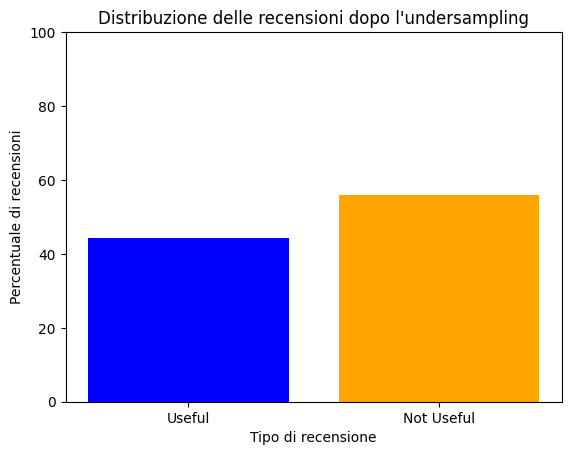

In [ ]:
useful_df = df_balanced.select("useful").toPandas()

# Calculate the count
useful_count = useful_df[useful_df["useful"] == 1].count()[0]
not_useful_count = useful_df[useful_df["useful"] == 0].count()[0]

# Calculate normalized proportions
total_count = useful_count + not_useful_count
useful_percent = (useful_count / total_count) * 100
not_useful_percent = (not_useful_count / total_count) * 100

labels = ['Useful', 'Not Useful']
percentages = [useful_percent, not_useful_percent]
colors = ['blue', 'orange']

plt.bar(labels, percentages, color=colors)

plt.xlabel('Tipo di recensione')
plt.ylabel('Percentuale di recensioni')

plt.title('Distribuzione delle recensioni dopo l\'undersampling')
plt.ylim(0, 100)
plt.show()


##4.2) Obtain the Bag-Of-Words(BoW)
The bag-of-words (BoW) is a way to represent a set of documents as numbers.

In [ ]:
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# Alias per creare una copia del dataframe
restricted_df = df_balanced.alias('restricted_df')

# Funzione per pulire il testo
def clean(input):
    import re
    return ''.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, list(re.sub('\n', ' ', input.lower())))))

# Creare una funzione UDF per applicare la pulizia del testo
udf_remove_not_characters = f.udf(clean, StringType())

# Applicare la pulizia del testo direttamente sulla colonna 'review'
restricted_df = restricted_df.withColumn('cleaned_review', udf_remove_not_characters(f.col('review')))

# Tokenization - break review text into list of its individual terms (words in this case)
tokenizer = Tokenizer(inputCol='cleaned_review', outputCol='review_words')
restricted_df = tokenizer.transform(restricted_df)

# Rimuovere le recensioni senza parole dopo il tokenization
restricted_df = restricted_df.filter(f.size(f.col('review_words')) > 0)

# Rimozione delle stop words
remover = StopWordsRemover(inputCol='review_words', outputCol='no_stop_words')
restricted_df = remover.transform(restricted_df)


In [ ]:

from nltk.stem import SnowballStemmer

# Inizializzazione di SparkSession
spark = SparkSession.builder \
    .appName("ProjectBigData") \
    .getOrCreate()

# Download dei dati per lo SnowballStemmer di NLTK
nltk.download('snowball_data')

[nltk_data] Downloading package snowball_data to /root/nltk_data...


True

In [ ]:

from pyspark.ml.feature import CountVectorizer


# Creazione dello stemmer
stemmer = SnowballStemmer('english')

# Definizione della funzione di stemming come UDF
stemming_udf = f.udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))

# Applicazione dello stemming al dataframe
stemmed_df = restricted_df.withColumn('stemmed_review', stemming_udf(f.col('no_stop_words')))

# Creazione dell'istanza di CountVectorizer
count_vectorizer = CountVectorizer(inputCol='no_stop_words', outputCol='BoW')

# Addestramento del modello di CountVectorizer
model = count_vectorizer.fit(stemmed_df)
restricted_df = model.transform(stemmed_df)



In [ ]:
columns_to_keep = ['review', 'cleaned_review', 'review_words', 'no_stop_words', 'stemmed_review', 'BoW', 'votes_up', 'useful']

restricted_df = restricted_df.select(*columns_to_keep)
restricted_df.printSchema()
restricted_df.head(1)

root
 |-- review: string (nullable = true)
 |-- cleaned_review: string (nullable = true)
 |-- review_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- no_stop_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- stemmed_review: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- BoW: vector (nullable = true)
 |-- votes_up: long (nullable = true)
 |-- useful: integer (nullable = true)



[Row(review='After about 200 hours  the game gets repetitive, but like.. come on, no matter what you pay for it, the value per hour is stellar compared to something like a movie.', cleaned_review='after about  hours  the game gets repetitive but like come on no matter what you pay for it the value per hour is stellar compared to something like a movie', review_words=['after', 'about', '', 'hours', '', 'the', 'game', 'gets', 'repetitive', 'but', 'like', 'come', 'on', 'no', 'matter', 'what', 'you', 'pay', 'for', 'it', 'the', 'value', 'per', 'hour', 'is', 'stellar', 'compared', 'to', 'something', 'like', 'a', 'movie'], no_stop_words=['', 'hours', '', 'game', 'gets', 'repetitive', 'like', 'come', 'matter', 'pay', 'value', 'per', 'hour', 'stellar', 'compared', 'something', 'like', 'movie'], stemmed_review=['', 'hour', '', 'game', 'get', 'repetit', 'like', 'come', 'matter', 'pay', 'valu', 'per', 'hour', 'stellar', 'compar', 'someth', 'like', 'movi'], BoW=SparseVector(27242, {0: 2.0, 1: 1.0, 

##4.3) Make prediction using Logistic Regression (BoW)

In [ ]:
# Split the dataframe in two - train & test
projected_df = restricted_df[['BoW', 'useful']]
trainDF, testDF = projected_df.randomSplit([0.6, 0.4], 0)
trainDF.count()
testDF.count()
from pyspark import StorageLevel
trainDF.persist(StorageLevel(True, True, True, True, 1))
testDF.persist(StorageLevel(True, True, True, True, 1))


DataFrame[BoW: vector, useful: int]

In [ ]:
projected_df.groupBy('useful').count().show()

+------+-----+
|useful|count|
+------+-----+
|     0| 5922|
|     1| 4688|
+------+-----+



###4.3.1) Logistic Regression
Since even after undersampling there is considerable imbalance among the classes in the dataset, I decided to consider weighted metrics in the case of precision,recall and f1-score.

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

# Crea un classificatore LogisticRegression
lr_model = LogisticRegression(featuresCol='BoW', labelCol='useful')

# Addestra il modello
model = lr_model.fit(trainDF)

# Effettua la predizione sul set di test
predictions = model.transform(testDF)

# Calcolo dell'accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='useful', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Calcolo dell'AUC
auc_evaluator = BinaryClassificationEvaluator(labelCol="useful", metricName="areaUnderROC")
auc = auc_evaluator.evaluate(predictions)
print("Area sotto la curva ROC (AUC):", auc)

# Creazione di un evaluator per la precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="useful", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print("Precision:", precision)

# Creazione di un evaluator per il recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="useful", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print("Recall:", recall)

# Creazione di un evaluator per l'F1-score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="useful", metricName="weightedFMeasure")
f1_score = f1_evaluator.evaluate(predictions)
print("F1-Score:", f1_score)

Accuracy: 0.5553993909580698
Area sotto la curva ROC (AUC): 0.5454228673902142
Precision: 0.5575937402111122
Recall: 0.5553993909580699
F1-Score: 0.5563315404453125


In [ ]:
summary = model.summary
# Utilizza l'attributo 'summary' per ottenere le statistiche del modello
print("Area sotto la curva ROC (AUC):", summary.areaUnderROC)
print("Precision:", summary.precisionByLabel)
print("Recall:", summary.recallByLabel)
print("F1-Score:", summary.fMeasureByLabel())

Area sotto la curva ROC (AUC): 0.9979553220897304
Precision: [0.981826764219967, 0.9772472957851548]
Recall: [0.992721632263453, 0.9444844989185291]
F1-Score: [0.9872441412043904, 0.9605866177818514]


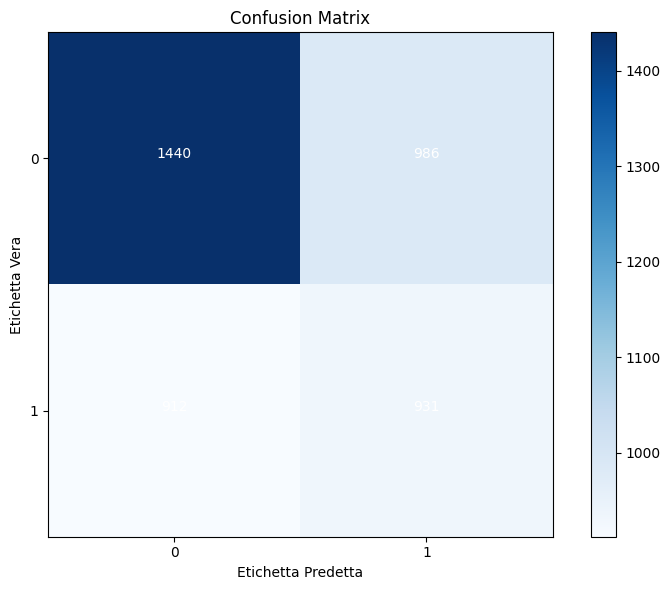

In [ ]:
import itertools

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Ottieni le etichette vere e le etichette predette dal dataframe di risultati
true_labels = predictions.select('useful').rdd.flatMap(lambda x: x).collect()
predicted_labels = predictions.select('prediction').rdd.flatMap(lambda x: x).collect()

# Calcola la confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Crea il plot della confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(set(true_labels)))
plt.xticks(tick_marks, sorted(set(true_labels)))
plt.yticks(tick_marks, sorted(set(true_labels)))
plt.xlabel('Etichetta Predetta')
plt.ylabel('Etichetta Vera')
plt.tight_layout()

# Aggiungi le etichette ai quadrati della confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()



In [ ]:

# Visualizza i risultati delle predizioni
predictions.select('useful', 'prediction', 'probability').show(n=50,truncate=False)

+------+----------+-------------------------------------------+
|useful|prediction|probability                                |
+------+----------+-------------------------------------------+
|1     |0.0       |[0.854202041464803,0.14579795853519695]    |
|1     |0.0       |[1.0,0.0]                                  |
|1     |0.0       |[1.0,0.0]                                  |
|1     |1.0       |[9.050590967495717E-12,0.9999999999909495] |
|1     |1.0       |[5.32402031724905E-86,1.0]                 |
|1     |1.0       |[1.160680255546007E-37,1.0]                |
|1     |1.0       |[1.3385871077681202E-14,0.9999999999999866]|
|1     |1.0       |[1.763516654667351E-17,1.0]                |
|1     |0.0       |[1.0,0.0]                                  |
|1     |1.0       |[0.017788884366617512,0.9822111156333825]  |
|1     |1.0       |[4.909298698367894E-6,0.9999950907013017]  |
|1     |0.0       |[1.0,0.0]                                  |
|1     |1.0       |[4.13067803433099E-11

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Crea un'istanza del classificatore LogisticRegression
lr = LogisticRegression(featuresCol='BoW', labelCol='useful', regParam=30)

# Addestra il modello
lr_model = lr.fit(trainDF)
# Calcola l'accuratezza del modello
evaluator = MulticlassClassificationEvaluator(labelCol='useful', metricName='accuracy')

train_accuracy = evaluator.evaluate(lr_model.transform(trainDF))
test_accuracy = evaluator.evaluate(lr_model.transform(testDF))

print(f"Train Logistic Regression accuracy: {(train_accuracy) * 100:.2f}")
print(f"Test Logistic Regression accuracy: {(test_accuracy) * 100:.2f}")


In [ ]:
testDF.show(4)

###4.3.2) Decision Tree

In [ ]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Crea un'istanza del classificatore DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol='BoW', labelCol='useful')

# Addestra il modello DecisionTreeClassifier
dt_model = dt.fit(trainDF)

# Calcola l'accuratezza dei modelli
evaluator = MulticlassClassificationEvaluator(labelCol='useful', metricName='accuracy')

train_dt_accuracy = evaluator.evaluate(dt_model.transform(trainDF))
test_dt_accuracy = evaluator.evaluate(dt_model.transform(testDF))

print(f"Train Decision Tree accuracy: {(train_dt_accuracy) * 100:.2f}")
print(f"Test Decision Tree accuracy: {(test_dt_accuracy) * 100:.2f}")


###4.3.3) Random Forest

In [ ]:

# Crea un'istanza del classificatore RandomForestClassifier
rf = RandomForestClassifier(featuresCol='BoW', labelCol='useful')

# Addestra il modello RandomForestClassifier
rf_model = rf.fit(trainDF)

train_rf_accuracy = evaluator.evaluate(rf_model.transform(trainDF))
test_rf_accuracy = evaluator.evaluate(rf_model.transform(testDF))

print(f"Train Random Forest accuracy: {(train_rf_accuracy) * 100:.2f}")
print(f"Test Random Forest accuracy: {(test_rf_accuracy) * 100:.2f}")
